#### VLP Size Distribution Script - Single Images

This script can be used for obtaining a rough distribution of spherical particle radii from an electron microscope image. At the least, it provides a distibution of a sample of particles from the image. For this script to work it is assumed that the particles are roughly circular in shape, and that the em image contrast is reasonably consistent across the image. 

The following packages are necessary to run this script:

 - python 3.5 with numpy and matplotlib
 - opencv3
 
Furthermore, the folder containing this notebook should contain an additional folder containing the image you would like to process.

Enjoy!

----------------------------

1) Import necessary packages - an error here will require installing the dependencies listed above.

In [1]:
import cv2
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

2) Specify the image location:

In [2]:
folder_name = "images"
image_name = "2.jpg"

location = os.getcwd() + "/"+folder_name +"/" + image_name

3) Let's plot the image to make sure that we have the right one:

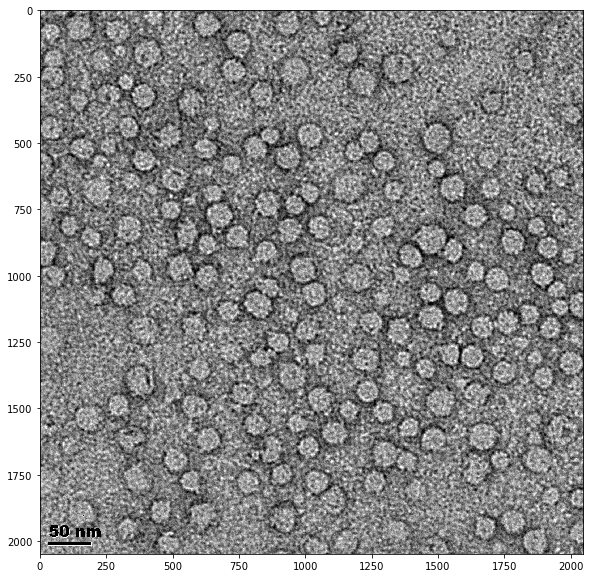

In [3]:
raw_image = cv2.imread(location,0)
plt.figure(figsize=(10,10))
_ = plt.imshow(raw_image,cmap='gray')

4) We need to calculate the pixel/nm ratio in order to size the particles.

Adjust the top/left/right parameters until the white bar is the same length as the scale bar of the image. It is also necessary to provide the stated length of the scale bar (in nm). If the scale bar is not situated in the bottom left of the image then the measuring sub-image will need to be manually calibrated.



Your bar is  164 pixels long. The pixel to nm ratio is:  0.3048780487804878


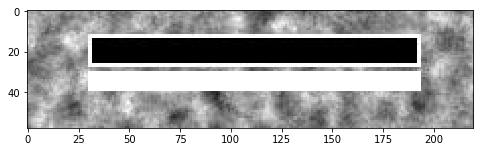

In [4]:
#---- Enter the parameters here ------

size_of_scalebar_in_nm = 50
top = 30
left = 30
right = 194

#-------------------------------------

measure = raw_image.copy()
measure = measure[1990:,0:220]
measure[top:top+10,left:right]=255

plt.figure(figsize=(8,8))
plt.imshow(measure,cmap='gray')

ptnm = size_of_scalebar_in_nm/(right-left)
print("Your bar is ", right-left, "pixels long. The pixel to nm ratio is: ", ptnm )

5) Now we are at the meat of the algorithm - i.e. the circle detection.

Basically, a blockwise median filter is applied to the image (well suited for smoothing greyscale static noise), after which the opencv HoughCircle detector method is used. There are multiple parameters which need to be selected - play around with these settings to get optimal performance:

 - pixel_filter_width: This determines the size (in pixels) of the square filter used for median filtering of the image - must be an odd number!
 - min_radius_in_nm: The minimum radius (in nm) you would like the algorithm to detect.
 - max_radius_in_nm: The maximum radius (in nm) you would like the algorithm to detect.
 - min-seperation_in_pixels: The minimum distance (in pixels) between detected circles. By default we set this to twice the minimum radius, to mitigate the detection of overlapping circles.
 - tuning_param_1: Controls the sensitivity of the algorithm to gradient contours.
 - tuning_param_2: Controls the sensitivity of the algorithm.
 
The result from this  first part of the algorithm may well have overlapping circles, these will be removed in a subsequent step.

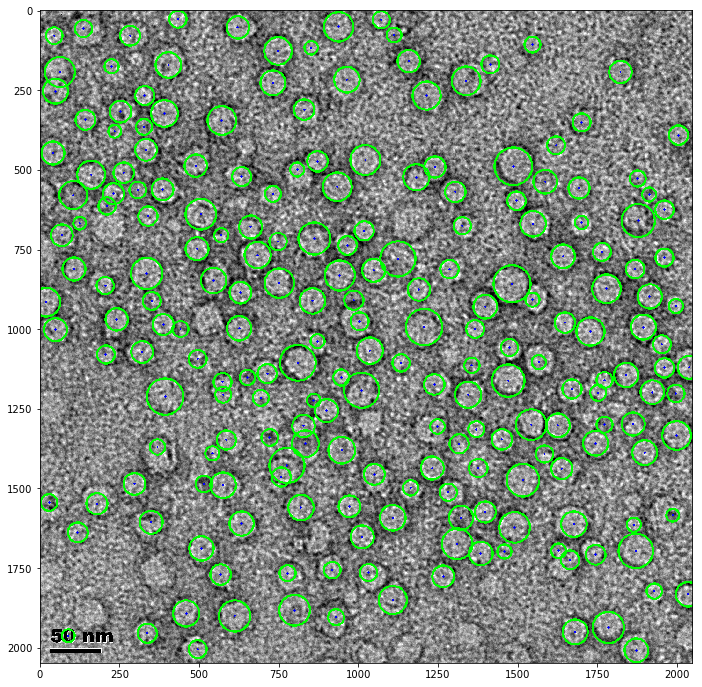

In [5]:
# ---- Enter the parameters here -------

pixel_filter_width = 21         # Higher number gives blurrier smoothing - recommond 11 to 21 (must be odd!)
min_radius_in_nm = 6                    
max_radius_in_nm = 18
tuning_param_1 = 40             # Higher number gives less sensitive detection - recommend 30 to 50
tuning_param_2 = 25             # Higher number gives less sensitive detection - recommend 18 to 35

min_seperation_in_pixels = int(np.floor((2*min_radius_in_nm)/ptnm))

# ---- Find the circles --------

min_radius_in_pixels = int(np.floor(min_radius_in_nm/ptnm))
max_radius_in_pixels = int(np.ceil(max_radius_in_nm/ptnm))

mf_image = cv2.medianBlur(raw_image,pixel_filter_width)      # Apply the median block filter     
circles = cv2.HoughCircles(mf_image,cv2.HOUGH_GRADIENT,1,    # Apply Hough Circle Detection implementation
                           min_seperation_in_pixels,
                           param1=tuning_param_1,
                           param2=tuning_param_2,
                           minRadius=min_radius_in_pixels,
                           maxRadius=max_radius_in_pixels)

# ---- Visualise the outcome ------

cimg = cv2.cvtColor(raw_image,cv2.COLOR_GRAY2BGR)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),5)
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plt.figure(figsize=(12,12))
_ = plt.imshow(cimg)

6) Now we remove overlapping circles:

We have detected 197 non-overlapping vlps.


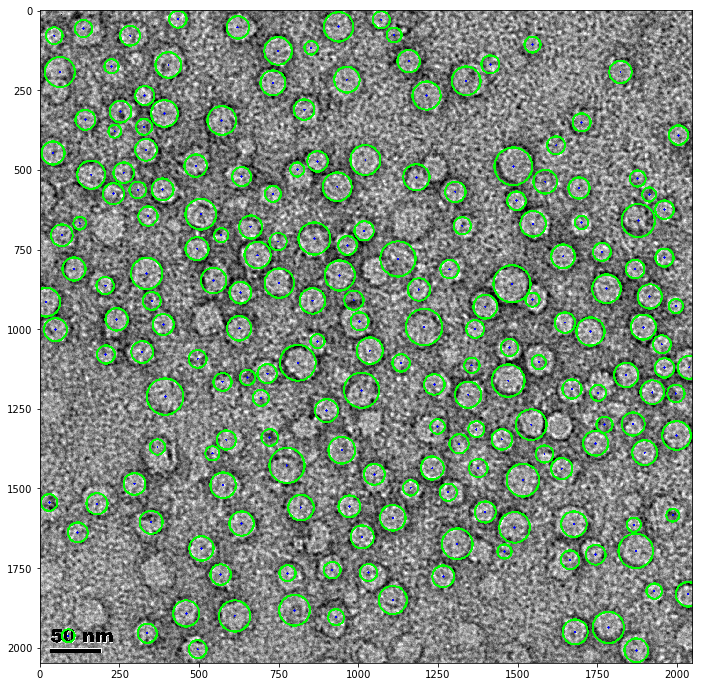

In [6]:
def get_check_ratio(circle_1,circle_2):
    centre_distance = np.linalg.norm([float(circle_1[0])-float(circle_2[0]),float(circle_1[1])-float(circle_2[1])])
    radiisum = float(circle_1[2])+float(circle_2[2])
    return centre_distance/radiisum

num_circles = circles.shape[1]
suppress = []
for j in range(num_circles):
    for k in range(j+1,num_circles):
        ratio = get_check_ratio(circles[0,j,:],circles[0,k,:])
        if ratio < 1:
            if circles[0,j,2] >= circles[0,k,2]:
                if k not in suppress:
                    suppress.append(k)
            else:
                if j not in suppress:
                    suppress.append(j)
                    
picks = [j for j in range(num_circles) if j not in suppress]
new_circles = circles[:,picks,:]

print("We have detected", len(picks), "non-overlapping vlps.")

# ------- visualize the results ---------

cimg2 = cv2.cvtColor(raw_image,cv2.COLOR_GRAY2BGR)
circles2 = np.uint16(np.around(new_circles))
for i in circles2[0,:]:
    cv2.circle(cimg2,(i[0],i[1]),i[2],(0,255,0),5)
    cv2.circle(cimg2,(i[0],i[1]),2,(0,0,255),3)
    
plt.figure(figsize=(12,12))
_ = plt.imshow(cimg2)

7) Finally we can plot the vlp size distribution histogram - number of bins must be specified.

The mean radius is: 10.4618051257 nm
The median radius is: 10.0609756098 nm


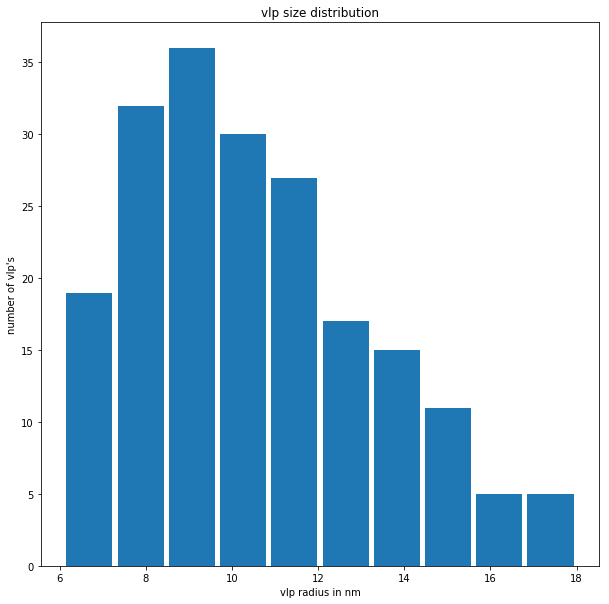

In [7]:
# ----- Enter number of bins here ------

n_bins = 10

# ---------------

radii_in_nm = new_circles[:,:,2][0,:]*ptnm

print("The mean radius is:",np.mean(radii_in_nm),"nm")
print("The median radius is:",np.median(radii_in_nm),"nm")

plt.figure(figsize=(10,10))
_ = plt.hist(radii_in_nm,rwidth=0.9,bins=n_bins)
plt.xlabel("vlp radius in nm")
plt.ylabel("number of vlp's")
_ = plt.title("vlp size distribution")